> **Note:** Run this notebook from the cloned `SummerSchool` repository using the `SummerSchool` conda environment described in the [README](README.md).

# Dimensionality Reduction & Clustering for Calcium Imaging

This notebook demonstrates key concepts in analyzing neural population activity:
- **Dimensionality reduction**: How to visualize high-dimensional neural data
- **Clustering**: Finding groups of neurons with similar activity patterns
- **Data preprocessing**: Essential steps for calcium imaging data

## Learning objectives:
1. Understand why we need dimensionality reduction for neural data
2. Compare linear (PCA) vs non-linear (t-SNE, UMAP) methods
3. Learn clustering techniques to find functional groups
4. Validate and interpret clustering results


In [9]:
# Dimensionality Reduction & Clustering for Calcium Imaging
# Simplified Lecture Version

# --- Standard Library ---
import warnings

# --- Scientific Libraries ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.stats import zscore
from scipy.io import loadmat
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from umap import UMAP


# --- Machine Learning ---
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from hdbscan import HDBSCAN

warnings.filterwarnings("ignore")

# Set style
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "Times New Roman", "DejaVu Serif"],
    "text.usetex": False,
    "axes.labelsize": 13,
    "axes.titlesize": 15,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.linewidth": 0.6,
    "axes.edgecolor": "0.2",
})
sns.set_theme(style="white", context="talk", palette="Set2")

print("=== DIMENSIONALITY REDUCTION & CLUSTERING FOR CALCIUM IMAGING ===")


=== DIMENSIONALITY REDUCTION & CLUSTERING FOR CALCIUM IMAGING ===



# 1. INTRODUCTION & DATA LOADING

**Why do we need dimensionality reduction?**
- Calcium imaging records activity from hundreds to thousands of neurons simultaneously
- Each neuron = one dimension → high-dimensional data
- Impossible to visualize directly
- Many neurons may have correlated activity patterns

**Our approach:**
1. Load calcium imaging data (neurons × time)
2. Clean and preprocess the data
3. Apply dimensionality reduction to find the main patterns
4. Use clustering to group neurons with similar activity

In [10]:
from scipy.io import loadmat

print("1. Loading Sample Data...")

np.random.seed(42)

# Selector for choosing the dataset
dataset_choice = "population"  # Change to "dendrites" to use the other dataset

if dataset_choice == "dendrites":
    # Load the .mat file for the tree dataset. these were variables directly stored in the .mat file
    mat_path = "Data/M1_dendritic_tree_data.mat"  # Update this path to the location of your .mat file
    mat_data = loadmat(mat_path)

    # Extract the variables
    behaviour = mat_data['behaviour'].squeeze()  # Squeeze to remove single-dimensional entries
    result = mat_data['result']
    tax = np.squeeze(mat_data['tax'].T)
    coords = mat_data['coords']

elif dataset_choice == "population":
    # Load the .mat file for the M1 dataset. # these were variables stored in a structure in the .mat file
    mat_path = "Data/M1_population_data.mat"  # Data exported from matlab
    mat_data = loadmat(mat_path)

    # Extract the variables
    mat_data = mat_data['mat_data']
    behaviour = mat_data['behaviour'][0, 0].squeeze()  # Indexing to access the nested structure and squeeze to remove single-dimensional entries
    result = mat_data['result'][0, 0]  # Indexing to access the nested structure
    tax = mat_data['tax'][0, 0].squeeze()  # Indexing to access the nested structure and squeeze to remove single-dimensional entries

# Get the dimensions
T, N = len(behaviour), result.shape[0]

# Ensure result shape is (Individuals, Timepoints)
print(result.shape) # N x T
print(tax.shape) # T x 1
print(behaviour.shape) # T x 1

# Align with existing variable names in this notebook
behavior = behaviour
calcium_data = result
time_axis = tax

# Replace non-finite values with NaN and remove invalid entries
calcium_data = np.where(np.isfinite(calcium_data), calcium_data, np.nan)
behavior = np.where(np.isfinite(behavior), behavior, np.nan)
initial_n_neurons, initial_n_timepoints = calcium_data.shape
valid_neurons = ~np.all(np.isnan(calcium_data), axis=1)
calcium_data = calcium_data[valid_neurons]
removed_neurons = initial_n_neurons - calcium_data.shape[0]

valid_timepoints = ~np.isnan(behavior)
valid_timepoints &= ~np.any(np.isnan(calcium_data), axis=0)
calcium_data = calcium_data[:, valid_timepoints]
behavior = behavior[valid_timepoints]
time_axis = time_axis[valid_timepoints]
removed_timepoints = initial_n_timepoints - calcium_data.shape[1]

n_neurons, n_timepoints = calcium_data.shape
print(f"Removed {removed_neurons} neurons and {removed_timepoints} timepoints with NaN")
print(f"Dataset cleaned: {n_neurons} neurons, {n_timepoints} timepoints")

assert not np.isnan(calcium_data).any()
assert not np.isnan(behavior).any()

1. Loading Sample Data...
(157, 16233)
(16233,)
(16233,)
Removed 0 neurons and 0 timepoints with NaN
Dataset cleaned: 157 neurons, 16233 timepoints



# 2. PRINCIPAL COMPONENT ANALYSIS (PCA)

**What is PCA?**
- **Goal**: Find the directions of maximum variance in high-dimensional data
- **Method**: Linear transformation that projects data onto lower dimensions
- **Output**: Principal components (PCs) ordered by explained variance

**Why use PCA for calcium imaging?**
- Reduces noise by focusing on main patterns
- Reveals coordinated activity across neuron populations  
- Fast and interpretable
- Good preprocessing step for other methods

**Key concepts:**
- **PC1**: Direction with highest variance (most important pattern)
- **Explained variance**: How much of the data's variability each PC captures
- **Loadings**: How much each original neuron contributes to each PC


Dataset: Population activity during behavior

3. Principal Component Analysis...


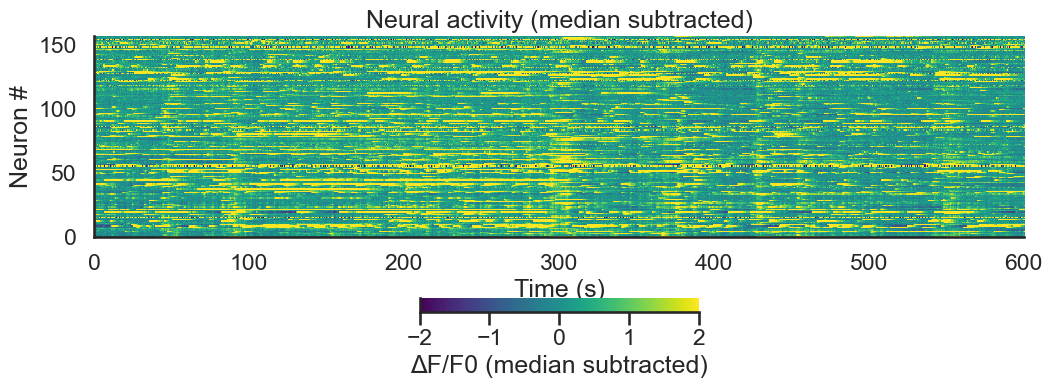

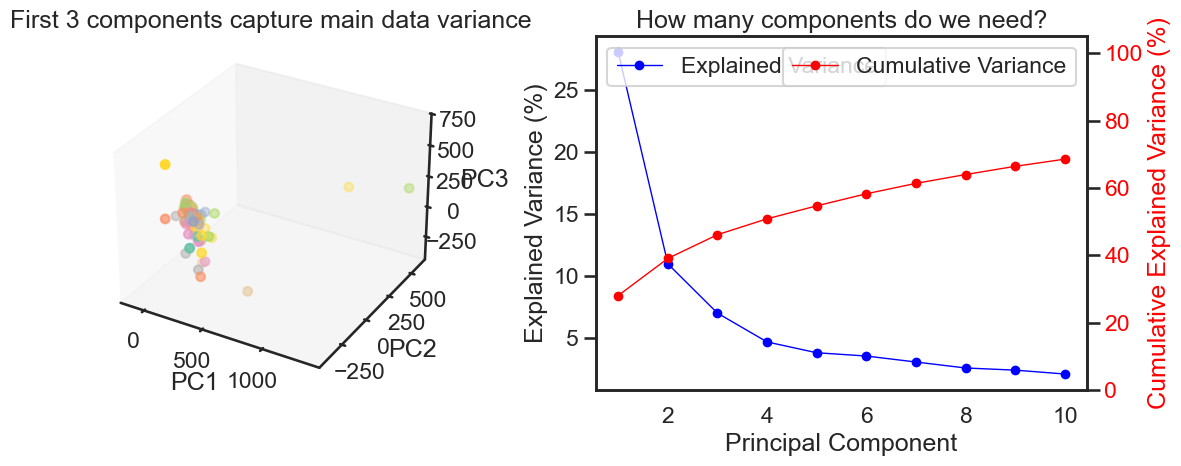

First 3 PCs explain 46.1% of variance


In [11]:
if dataset_choice == "dendrites":
    print("\nDataset: Dendritic tree activity during behavior")
    # remove global median of all cells from each neuron
    calcium_norm = calcium_data - np.median(calcium_data, axis=0)
else:
    print("\nDataset: Population activity during behavior")
    # classic neuroanl standarization: ΔF/F0
    F0 = np.percentile(calcium_data, 20, axis=1, keepdims=True)
    calcium_norm = (calcium_data - F0) / F0 # ΔF/F0

# show media subtracted data
plt.figure(figsize=(12, 4))
plt.imshow(
    calcium_norm,
    aspect="auto",
    cmap="viridis",
    extent=[time_axis[0], time_axis[-1], 0, n_neurons],
    vmin=-2,
    vmax=2,
    interpolation='none',  # Prevent line blending/smoothing
    )
cbar = plt.colorbar(orientation="horizontal", pad=0.2, label="ΔF/F0 (median subtracted)", shrink=0.3)
cbar.outline.set_visible(False)
plt.xlabel("Time (s)")
plt.ylabel("Neuron #")
plt.title("Neural activity (median subtracted)")
sns.despine()
plt.grid(False)

print("\n3. Principal Component Analysis...")

# Apply PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(calcium_norm)

# Figure 3: 3D PCA scatter plot
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                     c=range(n_neurons), cmap='Set2', s=40)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('First 3 components capture main data variance')
sns.despine()
ax1.grid(False)

# Figure 4: Explained variance plot and cumulative explained variance
ax2 = fig.add_subplot(122)
ax2.plot(range(1, 11), pca.explained_variance_ratio_*100, 'bo-', linewidth=1, markersize=6)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained Variance (%)')
ax2.set_title('How many components do we need?')

# Cumulative explained variance on right axis
ax2_right = ax2.twinx()
ax2_right.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_)*100, 'ro-', linewidth=1, markersize=6)
ax2_right.set_ylabel('Cumulative Explained Variance (%)', color='red')
ax2_right.tick_params(axis='y', labelcolor='red')

ax2.legend(['Explained Variance'], loc='upper left')
ax2_right.legend(['Cumulative Variance'], loc='upper right')
ax2.grid(False)

# Cap to 100%
ax2_right.set_ylim(0, 105)

plt.tight_layout()
plt.show()

print(f"First 3 PCs explain {pca.explained_variance_ratio_[:3].sum()*100:.1f}% of variance")


# 3. NON-LINEAR DIMENSIONALITY REDUCTION

**Limitations of PCA:**
- Only finds **linear** relationships
- May miss curved or complex patterns in neural activity
- Assumes data lies on a linear subspace

**Non-linear methods:**
- **t-SNE**: Great for visualization, preserves local neighborhoods
- **UMAP**: Faster than t-SNE, preserves both local and global structure

**Key parameters:**
- **Perplexity (t-SNE)**: How many neighbors to consider (typically 5-50)
- **n_neighbors (UMAP)**: Similar to perplexity (typically 5-100)


4. Non-linear Dimensionality Reduction...


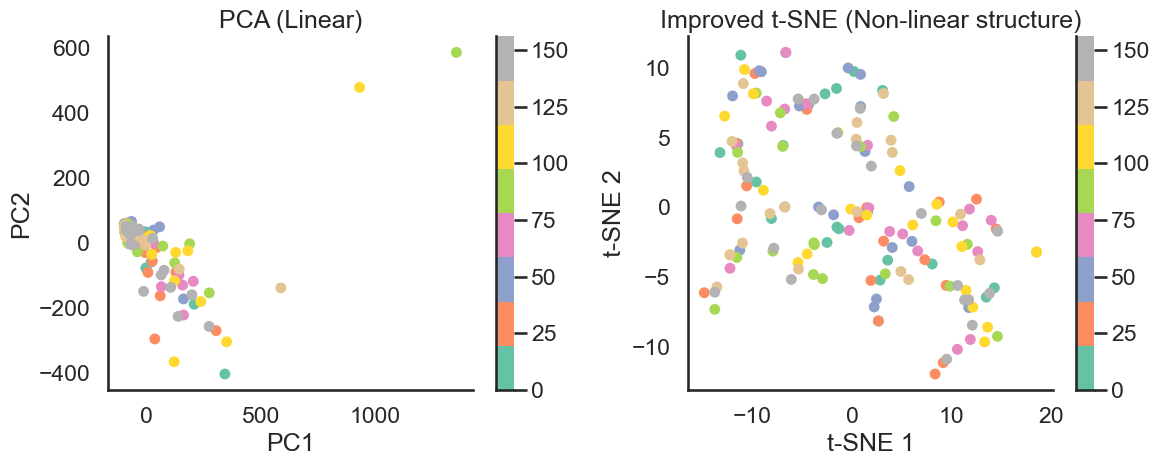

In [12]:
# Improved t-SNE: run on first 10 PCA components, increase perplexity, and add explanation
print("\n4. Non-linear Dimensionality Reduction...")

# PCA preprocessing for t-SNE (denoising, speed)
pca_for_tsne = PCA(n_components=10)
pca_data = pca_for_tsne.fit_transform(calcium_norm)

# Try higher perplexity (20-40 typical for moderate datasets)
tsne = TSNE(n_components=3, perplexity=3, learning_rate=10, init='pca')
tsne_result = tsne.fit_transform(pca_data)

# Figure: Compare PCA vs improved t-SNE
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=range(n_neurons), cmap='Set2', s=40)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (Linear)')
cbar = plt.colorbar()
cbar.outline.set_visible(False)
sns.despine()
plt.grid(False)

plt.subplot(1,2,2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=range(n_neurons), cmap='Set2', s=40)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Improved t-SNE (Non-linear structure)')
cbar = plt.colorbar()
cbar.outline.set_visible(False)
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

# Comment: t-SNE may still show poor structure if the data is noisy or lacks clear clusters. Try different perplexity values or cluster numbers for better results.


Consensus UMAP: Multiple runs to highlight stable structure
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20


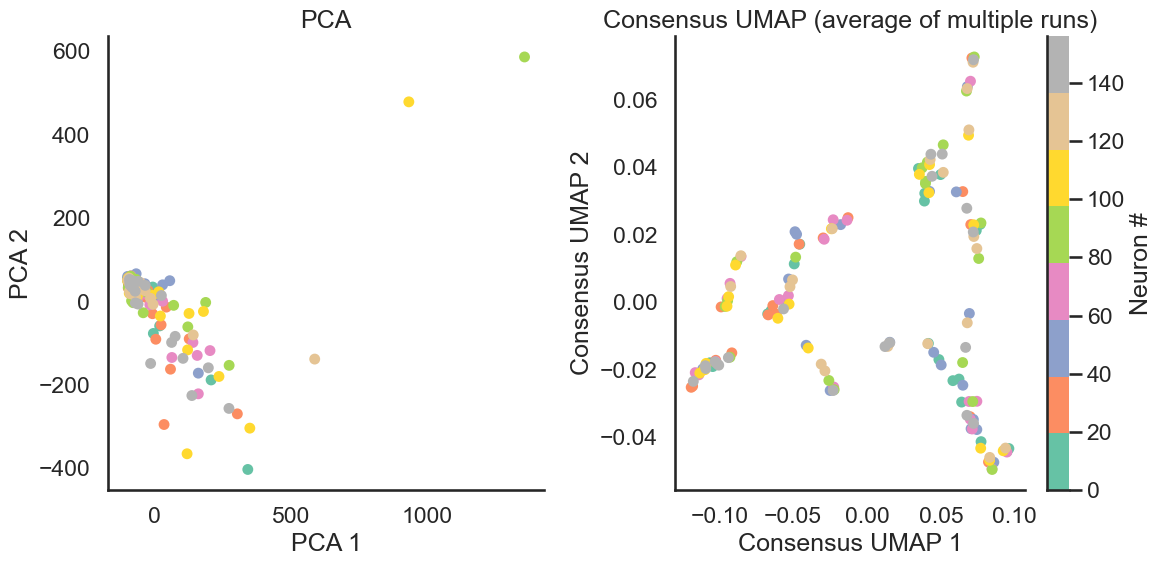

In [13]:
print("\nConsensus UMAP: Multiple runs to highlight stable structure")
# Consensus UMAP: run UMAP multiple times and visualize stable structure


def consensus_umap_procrustes(X, runs=20, n_neighbors=3, min_dist=0.1, seed=0, n_components=2):
    embs, ref = [], None
    for i in range(runs):
        print(f"Run {i+1}/{runs}")
        Y = UMAP(n_components=n_components, n_neighbors=n_neighbors,
                 min_dist=min_dist, random_state=seed+i).fit_transform(X)
        Y -= Y.mean(0); Y /= np.sqrt((Y**2).sum())      # center/normalize
        if ref is None: ref = Y
        U, _, Vt = np.linalg.svd(Y.T @ ref, full_matrices=False)
        embs.append(Y @ (U @ Vt))                       # orthogonal alignment
    return np.median(np.stack(embs), axis=0)

consensus_emb = consensus_umap_procrustes(pca_data)  # -> (n_samples, 2)


# Figure: Compare PCA vs improved UMAP
plt.figure(figsize=(12, 6))

# PCA plot
plt.subplot(1, 2, 1)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=range(n_neurons), cmap='Set2', s=40)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA')
sns.despine()
plt.grid(False)

# t-SNE plot
plt.subplot(1, 2, 2)
plt.scatter(consensus_emb[:, 0], consensus_emb[:, 1], c=range(n_neurons), cmap='Set2', s=40)
plt.xlabel('Consensus UMAP 1')
plt.ylabel('Consensus UMAP 2')
plt.title('Consensus UMAP (average of multiple runs)')
cbar = plt.colorbar(label="Neuron #")
cbar.outline.set_visible(False)
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()


# 4. CORRELATION ANALYSIS & CLUSTERING

**Why cluster neurons?**
- Find **functional groups**: neurons that work together
- Reduce complexity: instead of analyzing 1000s of neurons, analyze ~10 clusters
- Biological insight: clusters may correspond to cell types or functional units

**Two complementary approaches:**
1. **Correlation-based clustering**: Group neurons with similar activity patterns over time
2. **Embedding-based clustering**: Group neurons that are close in UMAP space

**Hierarchical clustering:**
- Builds a tree (dendrogram) showing how neurons group together
- Can choose any number of clusters by "cutting" the tree
- Good for exploring different cluster numbers

**HDBSCAN clustering:**
- Finds dense regions in UMAP space
- Automatically determines number of clusters
- Robust to noise (labels some points as "noise")


5. Improved Correlation Analysis & Clustering...


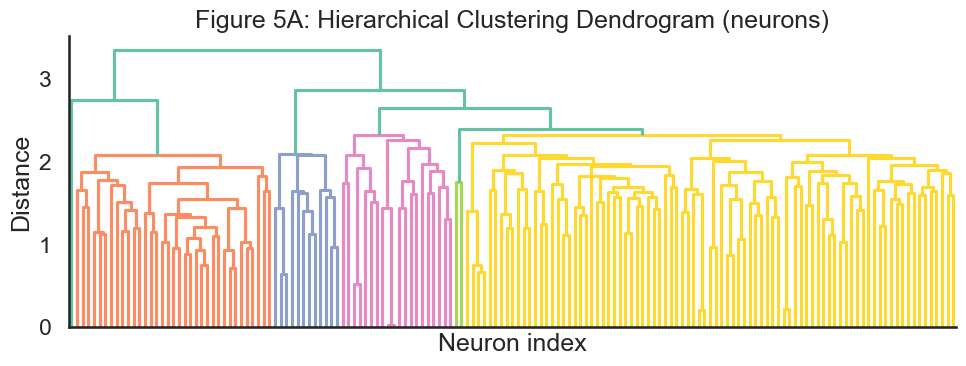

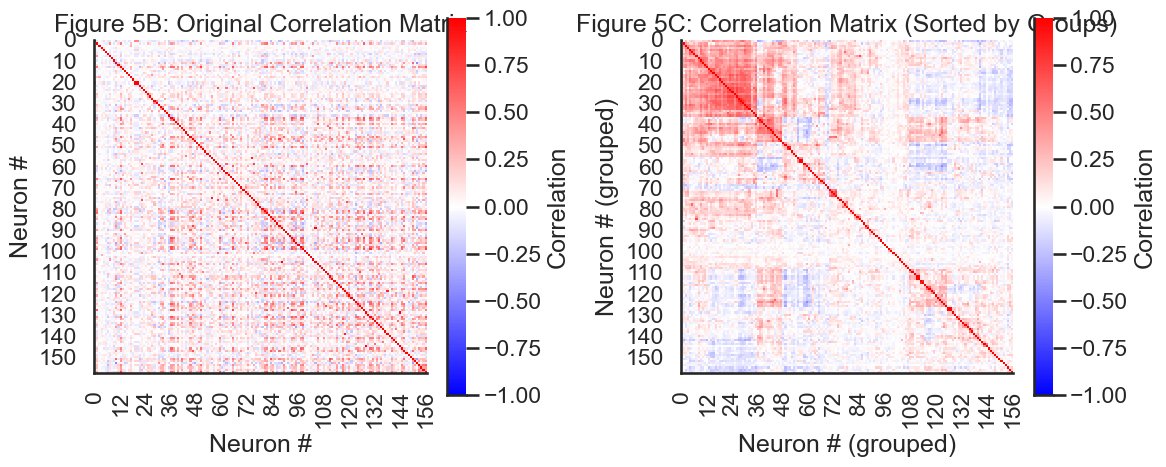

These figures show hierarchical clustering and correlation structure among neurons. The dendrogram (5A) reveals groupings, while the correlation matrices (5B, 5C) show how sorting by cluster clarifies group structure.


In [14]:
# Improved hierarchical clustering and dendrogram visualization for correlation matrix
print("\n5. Improved Correlation Analysis & Clustering...")

# Compute correlation matrix
corr_matrix = np.corrcoef(calcium_norm)

# Hierarchical clustering using linkage on correlation matrix (better group sorting)
linkage_matrix = linkage(corr_matrix, method='average')

# Figure 5A: Dendrogram for visualization of neuron groups
plt.figure(figsize=(10, 4))
dendro = dendrogram(linkage_matrix, no_labels=True, color_threshold=None)
plt.title('Figure 5A: Hierarchical Clustering Dendrogram (neurons)')
plt.xlabel('Neuron index')
plt.ylabel('Distance')
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

# Sort correlation matrix by dendrogram leaves (grouped neurons)
sort_idx = dendro['leaves']
corr_sorted = corr_matrix[sort_idx][:, sort_idx]

# Figure 5B: Correlation matrices (unsorted vs sorted by groups)
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
sns.heatmap(corr_matrix, cmap="bwr", vmin=-1, vmax=1, square=True, cbar_kws={"label": "Correlation"}, ax=ax1)
ax1.set_title("Figure 5B: Original Correlation Matrix")
ax1.set_xlabel("Neuron #")
ax1.set_ylabel("Neuron #")
sns.despine()
ax1.grid(False)

ax2 = plt.subplot(1, 2, 2)
sns.heatmap(corr_sorted, cmap="bwr", vmin=-1, vmax=1, square=True, cbar_kws={"label": "Correlation"}, ax=ax2)
ax2.set_title("Figure 5C: Correlation Matrix (Sorted by Groups)")
ax2.set_xlabel("Neuron # (grouped)")
ax2.set_ylabel("Neuron # (grouped)")
sns.despine()
ax2.grid(False)

plt.tight_layout()
plt.show()

# Context:
print("These figures show hierarchical clustering and correlation structure among neurons. The dendrogram (5A) reveals groupings, while the correlation matrices (5B, 5C) show how sorting by cluster clarifies group structure.")


5. Clustering (HDBSCAN on UMAP) and corr matrix reordered by clusters...


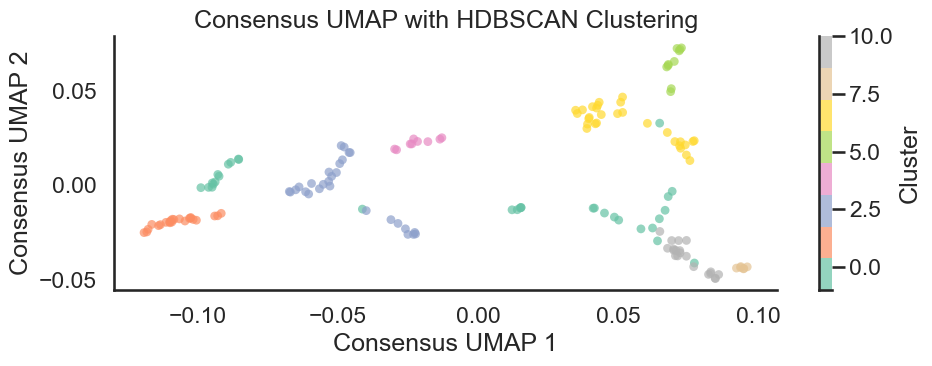

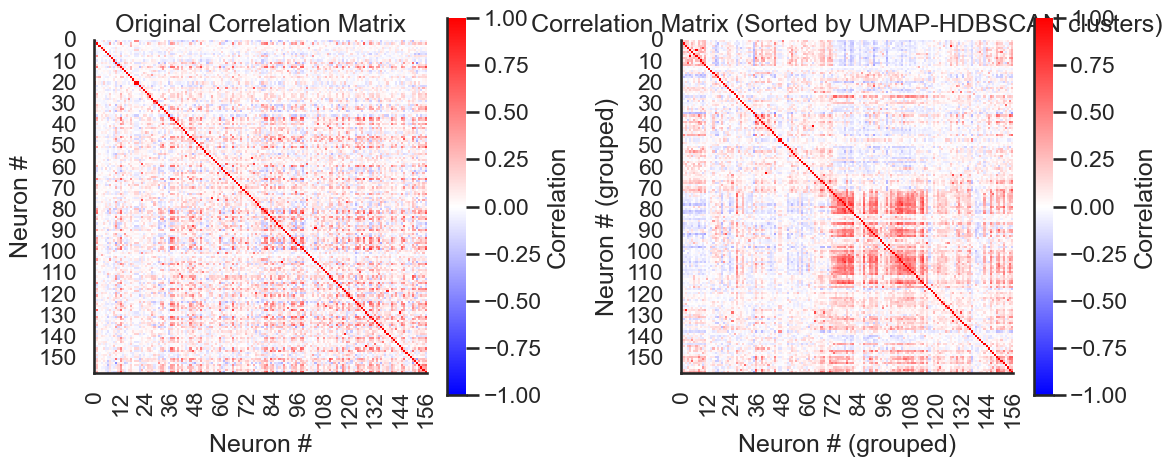

In [15]:
# HDBSCAN on UMAP coordinates + correlation reordered by UMAP clusters
print("\n5. Clustering (HDBSCAN on UMAP) and corr matrix reordered by clusters...")

# Run HDBSCAN on the consensus UMAP embedding
clusterer = HDBSCAN(min_cluster_size=5)
cluster_labels = clusterer.fit_predict(consensus_emb)

# Visualization: UMAP colored by HDBSCAN clusters
plt.figure(figsize=(10, 4))
scatter = plt.scatter(
    consensus_emb[:, 0],
    consensus_emb[:, 1],
    c=cluster_labels,
    cmap='Set2',
    alpha=0.7,
    s=40,
    edgecolor="none",
)
cbar = plt.colorbar(scatter, label="Cluster")
cbar.outline.set_visible(False)
plt.title('Consensus UMAP with HDBSCAN Clustering')
plt.xlabel('Consensus UMAP 1')
plt.ylabel('Consensus UMAP 2')
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

# Build correlation matrix (neurons x neurons)
corr_matrix = np.corrcoef(calcium_norm)

# Reorder indices by cluster label (put noise = -1 at the end)
unique_labels = [c for c in np.unique(cluster_labels) if c != -1]
ordered_indices = []
for c in unique_labels:
    ordered_indices.append(np.where(cluster_labels == c)[0])
noise_indices = np.where(cluster_labels == -1)[0]
if noise_indices.size > 0:
    ordered_indices.append(noise_indices)
sort_idx = np.concatenate(ordered_indices) if len(ordered_indices) else np.arange(corr_matrix.shape[0])

# Apply ordering to correlation matrix
corr_sorted = corr_matrix[sort_idx][:, sort_idx]

# Show original vs UMAP-cluster-sorted correlation matrices for comparison
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
im1 = sns.heatmap(corr_matrix, cmap="bwr", vmin=-1, vmax=1, square=True, cbar_kws={"label": "Correlation"}, ax=ax1)
cbar1 = im1.collections[0].colorbar
cbar1.outline.set_visible(False)
ax1.set_title("Original Correlation Matrix")
ax1.set_xlabel("Neuron #")
ax1.set_ylabel("Neuron #")
sns.despine()
ax1.grid(False)

ax2 = plt.subplot(1, 2, 2)
im2 = sns.heatmap(corr_sorted, cmap="bwr", vmin=-1, vmax=1, square=True, cbar_kws={"label": "Correlation"}, ax=ax2)
cbar2 = im2.collections[0].colorbar
cbar2.outline.set_visible(False)
ax2.set_title("Correlation Matrix (Sorted by UMAP-HDBSCAN clusters)")
ax2.set_xlabel("Neuron # (grouped)")
ax2.set_ylabel("Neuron # (grouped)")
sns.despine()
ax2.grid(False)

plt.tight_layout()
plt.show()

# 5. CLUSTER VALIDATION & INTERPRETATION

**Why validate clusters?**
- Clustering algorithms always produce clusters, even from random data!
- Need to check if clusters are meaningful
- Compare different methods to assess robustness

**Validation approaches:**
1. **Visual inspection**: Do clusters make sense in low-D space?
2. **Cross-method comparison**: Do different algorithms find similar groups?
3. **Functional analysis**: Do clusters have distinct activity patterns?

**What to look for:**
- **Agreement between methods**: Similar clusters suggest robust structure
- **Distinct cluster profiles**: Each cluster should have unique temporal dynamics
- **Biological plausibility**: Do clusters make sense given known neuroscience?


6. Cluster Validation...


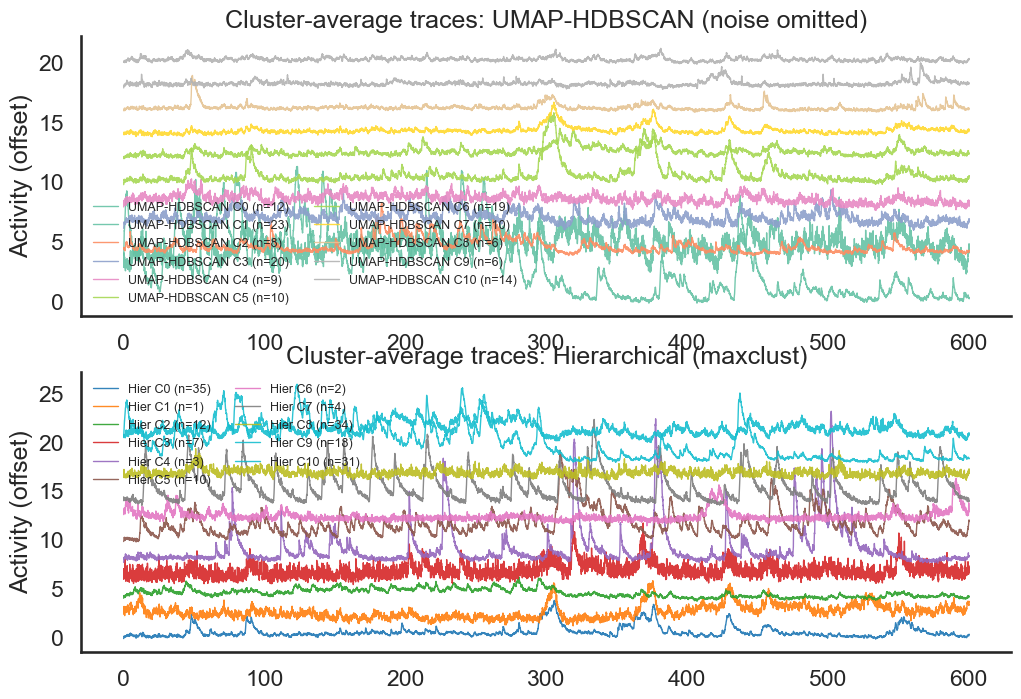

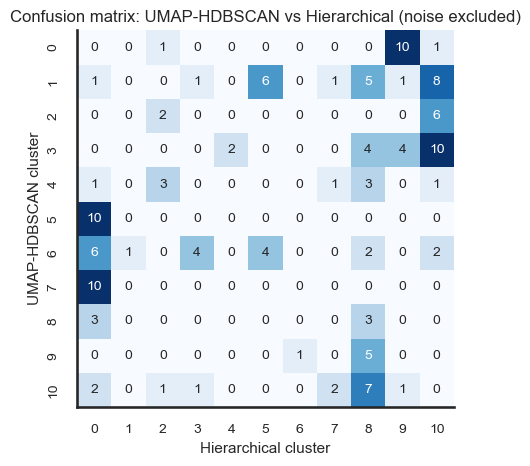


=== RESULTS SUMMARY ===
Dataset: 157 neurons, 16233 timepoints
PCA: First 3 components explain 46.1% of variance
UMAP-HDBSCAN: 11 clusters (+ noise=20)
Hierarchical: 11 clusters
  UMAP-HDBSCAN cluster 0: 12 neurons
  UMAP-HDBSCAN cluster 1: 23 neurons
  UMAP-HDBSCAN cluster 2: 8 neurons
  UMAP-HDBSCAN cluster 3: 20 neurons
  UMAP-HDBSCAN cluster 4: 9 neurons
  UMAP-HDBSCAN cluster 5: 10 neurons
  UMAP-HDBSCAN cluster 6: 19 neurons
  UMAP-HDBSCAN cluster 7: 10 neurons
  UMAP-HDBSCAN cluster 8: 6 neurons
  UMAP-HDBSCAN cluster 9: 6 neurons
  UMAP-HDBSCAN cluster 10: 14 neurons
  Hierarchical cluster 0: 35 neurons
  Hierarchical cluster 1: 1 neurons
  Hierarchical cluster 2: 12 neurons
  Hierarchical cluster 3: 7 neurons
  Hierarchical cluster 4: 3 neurons
  Hierarchical cluster 5: 10 neurons
  Hierarchical cluster 6: 2 neurons
  Hierarchical cluster 7: 4 neurons
  Hierarchical cluster 8: 34 neurons
  Hierarchical cluster 9: 18 neurons
  Hierarchical cluster 10: 31 neurons

=== INTERPRET

In [16]:
print("\n6. Cluster Validation...")

# Prepare both clustering labelings:
labels_umap = cluster_labels  # HDBSCAN on UMAP
labels_hier = None

# Recover hierarchical labels by cutting the dendrogram into k groups matching UMAP clusters (approx)
try:
    from scipy.cluster.hierarchy import fcluster
    # If linkage_matrix and corr_matrix exist from earlier cell, use them; otherwise recompute quickly
    if 'linkage_matrix' not in globals():
        corr_matrix = np.corrcoef(calcium_norm)
        linkage_matrix = linkage(corr_matrix, method='average')
    # Choose number of clusters as number of non-noise clusters in HDBSCAN
    k_umap = len([c for c in np.unique(labels_umap) if c != -1])
    k_hier = max(k_umap, 2) if k_umap > 0 else 2
    labels_hier = fcluster(linkage_matrix, k_hier, criterion='maxclust') - 1  # 0-based
except Exception as e:
    print(f"Warning: hierarchical labels could not be computed: {e}")
    # Fallback: treat all as one cluster
    labels_hier = np.zeros_like(labels_umap)

# Compute cluster-average traces for UMAP-HDBSCAN (excluding noise for means)
valid_idx_umap = labels_umap != -1
unique_umap = [c for c in np.unique(labels_umap) if c != -1]
n_umap = len(unique_umap)
means_umap = np.zeros((n_umap, n_timepoints))
for j, c in enumerate(unique_umap):
    means_umap[j] = calcium_norm[labels_umap == c].mean(axis=0)

# Compute cluster-average traces for hierarchical clustering
unique_hier = np.unique(labels_hier)
n_hier = len(unique_hier)
means_hier = np.zeros((n_hier, n_timepoints))
for j, c in enumerate(unique_hier):
    means_hier[j] = calcium_norm[labels_hier == c].mean(axis=0)

# Plot: traces for both methods (two stacked subplots) + confusion matrix
plt.figure(figsize=(12, 8))

# Top: UMAP-HDBSCAN traces
ax1 = plt.subplot(2,1,1)
cmap_umap = cm.get_cmap('Set2', max(n_umap, 1))
for j, c in enumerate(unique_umap):
    ax1.plot(time_axis, means_umap[j] + j*2, color=cmap_umap(j), linewidth=1, alpha=0.9, label=f'UMAP-HDBSCAN C{c} (n={(labels_umap==c).sum()})')
ax1.set_ylabel('Activity (offset)')
ax1.set_title('Cluster-average traces: UMAP-HDBSCAN (noise omitted)')
ax1.legend(frameon=False, fontsize=9, ncol=2)
sns.despine()
ax1.grid(False)

# Middle: Hierarchical traces
ax2 = plt.subplot(2,1,2, sharex=ax1)
cmap_hier = cm.get_cmap('tab10', max(n_hier, 1))
for j, c in enumerate(unique_hier):
    ax2.plot(time_axis, means_hier[j] + j*2, color=cmap_hier(j), linewidth=1, alpha=0.9, label=f'Hier C{c} (n={(labels_hier==c).sum()})')
ax2.set_ylabel('Activity (offset)')
ax2.set_title('Cluster-average traces: Hierarchical (maxclust)')
ax2.legend(frameon=False, fontsize=9, ncol=2)
sns.despine()
ax2.grid(False)

# Bottom: Confusion matrix between methods (ignoring noise in UMAP)
from sklearn.metrics import confusion_matrix
mask = labels_umap != -1
if mask.sum() == 0:
    conf_mat = np.zeros((1,1), dtype=int)
    labels_umap_relab = np.array([0])
    labels_hier_sel = np.array([0])
else:
    # Relabel UMAP clusters to 0..n-1 in the order of unique_umap
    relabel_map = {c:i for i, c in enumerate(unique_umap)}
    labels_umap_relab = np.array([relabel_map[c] for c in labels_umap[mask]])
    labels_hier_sel = labels_hier[mask]

conf_mat = confusion_matrix(labels_umap_relab, labels_hier_sel)
fig, ax = plt.subplots(figsize=(6, 5))
im = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"fontsize":10})
ax.set_xlabel('Hierarchical cluster', fontsize=11)
ax.set_ylabel('UMAP-HDBSCAN cluster', fontsize=11)
ax.set_title('Confusion matrix: UMAP-HDBSCAN vs Hierarchical (noise excluded)', fontsize=12)
ax.tick_params(axis='both', labelsize=10)
sns.despine()
plt.tight_layout()
plt.show()

# Summary
print("\n=== RESULTS SUMMARY ===")
print(f"Dataset: {n_neurons} neurons, {n_timepoints} timepoints")
print(f"PCA: First 3 components explain {pca.explained_variance_ratio_[:3].sum()*100:.1f}% of variance")
print(f"UMAP-HDBSCAN: {n_umap} clusters (+ noise={np.sum(labels_umap==-1)})")
print(f"Hierarchical: {n_hier} clusters")
for j, c in enumerate(unique_umap):
    print(f"  UMAP-HDBSCAN cluster {c}: {(labels_umap==c).sum()} neurons")
for j, c in enumerate(unique_hier):
    print(f"  Hierarchical cluster {c}: {(labels_hier==c).sum()} neurons")

print("\n=== INTERPRETATION ===")
print("- UMAP-HDBSCAN and hierarchical clustering yield complementary groupings.")
print("- Confusion matrix shows agreement/mismatch between methods (noise omitted).")
print("- Compare trace shapes across methods to assess stability of functional groups.")